# Implementing a basic neural network
By Brett Naul (UC Berkeley)

In this exercise we'll implement and train a simple single-layer neural network classifier using `numpy`. First, let's create some example data: we'll sample points from along interlocking spirals like we saw in the [TensorFlow playground](http://playground.tensorflow.org/#dataset=spiral).

*Based on Stanford CS 231n "Neural Network Case Study" exercise.*

In [1]:
# Imports / plotting configuration
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
plt.rcParams['image.interpolation'] = 'nearest'  # hard classification boundaries
plt.rcParams['image.cmap'] = 'viridis'
np.random.seed(13)

In [2]:
# Generate spiral sample data
def spiral_data(N, K=3, sigma=0.1):
    X = np.zeros((N * K, 2))
    y = np.zeros(N * K, dtype='int')

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        theta = 2 * np.pi * j / K + np.linspace(0, 3 * np.pi, N) + np.random.randn(N) * sigma
        X[ix] = np.c_[r * np.sin(theta), r * np.cos(theta)]
        y[ix] = j
        
    return X, y

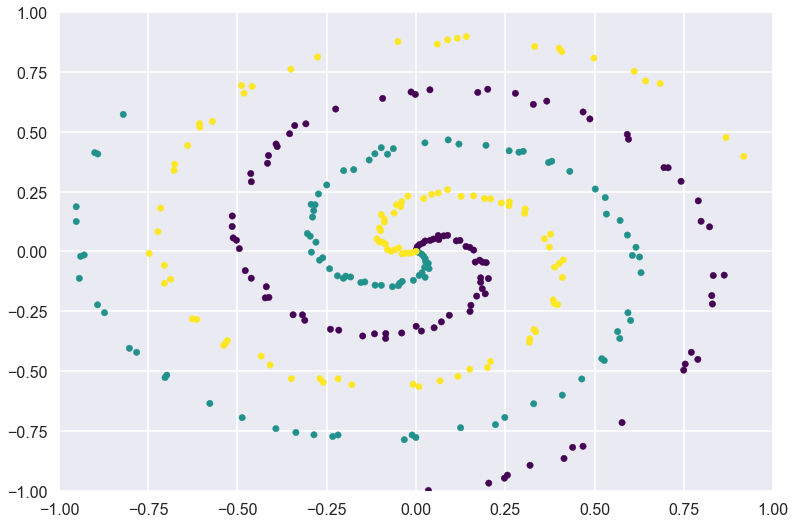

In [3]:
N = 100
K = 3
X, y = spiral_data(N, K, 0.1)

# Visualize the generated data
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
plt.xlim([-1, 1])
plt.ylim([-1, 1]);

## Setup
Our neural network will take an $\mathbf{x} = (x_1, x_2)$ vector as input and output a $K$-dimensional vector $\mathbf{p}=(p_1,\dots,p_K)$ of class probabilities. For simplicity we'll focus on a single choice of activation function, the ReLU function $f(x) = \max(x, 0)$.
![Perceptron diagram](perceptron.png)
We'll follow the `scikit-learn` model API and construct a simple model with `fit` and `predict` methods. The exercises below will step you through the necessary steps to implement a fully-functional neural network classifier. 

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SingleLayerReLU(BaseEstimator, ClassifierMixin):
    """Skeleton code for single-layer multi-class neural network classifier w/ ReLU activation.
    NOTE: Whenever you change the code below, you need to re-run this cell AND re-initialize
    your model (`model = SingleLayerNet(...)`) in order to update your specific `model` object.
    """
    def __init__(self, hidden_size, num_classes, sigma_init=0.01):
        """Initialize weights with Gaussian noise scaled by `sigma_init` and
        biases with zeros.
        """
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.W1 = sigma_init * np.random.randn(hidden_size, 2)
        self.W2 = sigma_init * np.random.randn(num_classes, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.b2 = np.zeros(num_classes)
    
    def loss(self, y, P):
        """Compute total softmax loss.
        Inputs:  y -> (N,) array of true (integer) labels
                 p -> (N, K) array of predicted probabilities
        Outputs: L -> total loss value       
        """
        return -np.sum(np.log(P[range(len(P)), y]))
        
    def dloss(self, X, y):
        """Compute gradient of softmax loss with respect to network weights.
        Inputs:  X -> (N, 2) array of network inputs
                 y -> (N,) array of true labels
        Outputs: dW1 -> (hidden_size, 2) array of weight derivatives
                 dW2 -> (hidden_size, 2) array of weight derivatives
                 db1 -> (hidden_size,) array of bias derivatives
                 db2 -> (hidden_size,) array of bias derivatives
        """
        H = np.maximum(0, X @ self.W1.T + self.b1)  # ReLU activation
        Z = H @ self.W2.T + self.b2
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

        dZ = P
        dZ[range(len(X)), y] -= 1

        dW2 = (H.T @ dZ).T
        db2 = np.sum(dZ, axis=0)

        dH = dZ @ self.W2
        dH[H <= 0] = 0  # backprop ReLU  activation

        dW1 = (X.T @ dH).T
        db1 = np.sum(dH, axis=0)
        
        return (dW1, dW2, db1, db2)

    def predict_proba(self, X):
        """Compute forward pass for all input values.
        Inputs:  X -> (N, 2) array of network inputs
        Outputs: P -> (N, K) array of class probabilities
        """
        H = np.maximum(0, X @ self.W1.T + self.b1)  # ReLU activation
        Z = H @ self.W2.T + self.b2
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        
        return P
        
    def predict(self, X):
        """Compute most likely class labels for all input values.
        Inputs:  X -> (N, 2) array of network inputs
        Outputs: P -> (N, K) array of class probabilities
        """
        P = self.predict_proba(X)
        return np.argmax(P, 1)
        
    def fit(self, X, y, step_size=3e-3, n_iter=10000):
        """Optimize model parameters W1, W2, b1, b2 via gradient descent.
        Inputs:  X -> (N, 2) array of network inputs
                 y -> (N,) array of true labels
                 step_size -> gradient descent step size
                 n_iter -> number of gradient descent steps to perform
        Outputs: losses -> (n_iter,) array of loss values after each step
        """
        losses = np.zeros(n_iter + 1)
        for i in range(0, n_iter + 1):
            dW1, dW2, db1, db2 = self.dloss(X, y)
            self.W1 -= step_size * dW1
            self.W2 -= step_size * dW2
            self.b1 -= step_size * db1
            self.b2 -= step_size * db2
            
            P = self.predict_proba(X)
            losses[i] = self.loss(y, P)
            
            if i % 1000 == 0:
                print("Iteration {}: loss={}".format(i, losses[i]))
        return losses

## Part 1: Forward pass
The "forward pass" step (i.e., computing the output for a given input) can be written as
$$
\begin{align}
\mathbf{h} &= f(W_1 \mathbf{x} + \mathbf{b_1}) \\
\mathbf{z} &= W_2 \mathbf{h} + \mathbf{b_2} \\
\mathbf{p} &= \operatorname{softmax}(\mathbf{z})
\end{align}
$$
where $f(\cdot)$ is an activation function, $W_1$ and $W_2$ are weight matrices, and $\mathbf{b}_1$ and $\mathbf{b}_2$ are bias vectors. The softmax function is given by
$$
\operatorname{softmax}(\mathbf{z}) = \exp\left(\mathbf{z}\right) / \left(\sum_{k=1}^K \exp\left( z_k\right)\right)
$$
and the ReLU activation is
$$
f(x) = \max(x, 0).
$$

### 1a) Implement `predict` function
Your function should loop over the input points (i.e., the rows of $X$) and compute the estimated class probabilities for each. The model parameters $W_1, W_2, b_1, b_2$ are treated as fixed.

### 1b) Examine predictions
The function `visualize_predictions` below can be used to inspect the decision boundaries for a given model, dataset, and class labels. Initialize a network and see what the classifications look like. Try varying the number of hidden units and see how the decision boundary shapes change.

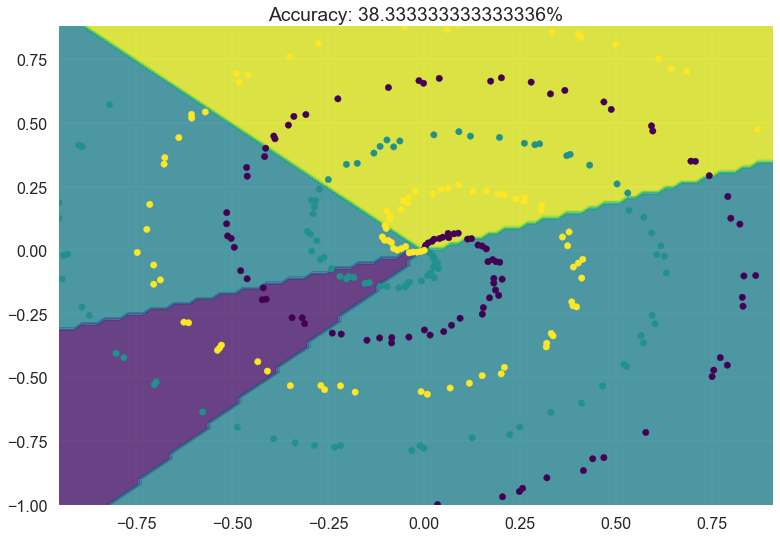

In [5]:
def visualize_predictions(model, X, y, step=0.02):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Accuracy: {}%".format(100 * np.mean(y == model.predict(X))))
    
model = SingleLayerReLU(100, K)
visualize_predictions(model, X, y)

## Part 2: Training
Obviously generating classifications at random isn't the way to go. Now we'll use gradient descent to iteratively improve the weights of our network and hopefully improve our classification accuracy.

If $y$ is some true label and $\mathbf{p}$ are the estimated class probabilities from our network, then our loss function for a single training example can be written as
$$L(y, \mathbf{p}) = -\log p_y,$$
that is, the negative log of the predicted probability for the true class: 0 if our predicted probability was 1, and $+\infty$ if it was 0.
In order to perform gradient descent, we'll need the derivatives of the loss with respect to all of our model parameters<sup>*</sup>. We can compute these derivatives via the backpropagation (effectively just the chain rule)<sup>**</sup>:
$$
\begin{aligned}
\frac{\partial L}{\partial z_k}   &= p_k - \text{\{1 if $y=k$, 0 otherwise\}} \\
\frac{\partial L}{\partial W_2}          &= \mathbf{h} \left(\frac{\partial L}{\partial \mathbf{z}}\right)^T \\
\frac{\partial L}{\partial \mathbf{b}_2} &= \frac{\partial L}{\partial \mathbf{z}}\\
\frac{\partial L}{\partial \mathbf{h}}   &= W_2 \frac{\partial L}{\partial \mathbf{z}} \circ f'(\mathbf{h}) \\
\frac{\partial L}{\partial W_1}          &= \mathbf{x} \left(\frac{\partial L}{\partial \mathbf{h}}\right)^T\\
\frac{\partial L}{\partial \mathbf{b}_1} &= \frac{\partial L}{\partial \mathbf{h}}\\
\end{aligned}
$$
Even for very deep or complicated networks, the gradient of the loss function can always be decomposed in this way, one connection at a time.

The actual quantity we wish to minimize is the sum of this loss value over all the samples in our data set. The gradient of this total loss is just the sum of the gradient for each sample.

### 2a) Implement `fit` function
Our gradient descent training consists of the following steps:
- Compute loss gradient with respect to model parameters using `dloss`. Note: for the sake of efficiency, this function returns the sum of the gradient of over all samples, so you should pass in the entire dataset.
- Update model parameters as $W_i \leftarrow W_i - \alpha\frac{\partial{L}}{\partial W_i}$ and $\mathbf{b}_i \leftarrow \mathbf{b}_i - \alpha\frac{\partial{L}}{\partial \mathbf{b}_i}$, where $\alpha$ is some chosen step size.
- Repeat for `num_iter` iterations.

Implement these steps in the `fit` function above. Check that the loss function is decreasing, either by occasionaly printing the loss value or by returning the losses from each step and plotting the trajectory.

### 2b) Examine predictions for fitted model
Train a model and examine the predictions using `visualize_predictions`. Repeat for a few combinations hidden layer sizes, gradient descent step sizes, and numbers of training iterations. What's the best accuracy you can achieve? How does the loss curve change with the step size?

Iteration 0: loss=329.57930627191524
Iteration 1000: loss=310.6331224673453
Iteration 2000: loss=273.460748916594
Iteration 3000: loss=225.0767687093133
Iteration 4000: loss=195.3647105015524
Iteration 5000: loss=152.70875944722872
Iteration 6000: loss=102.39551113743622
Iteration 7000: loss=72.67565326549212
Iteration 8000: loss=56.80889038747843
Iteration 9000: loss=46.52883268212207
Iteration 10000: loss=38.746580294266785
Iteration 11000: loss=38.27850528694245
Iteration 12000: loss=24.65057428256698
Iteration 13000: loss=19.798814344259785
Iteration 14000: loss=17.31626718340179
Iteration 15000: loss=16.183157169163632
Iteration 16000: loss=29.174083955576222
Iteration 17000: loss=24.461429225271697
Iteration 18000: loss=22.864455406130947
Iteration 19000: loss=18.314011745445065
Iteration 20000: loss=15.46306636879013


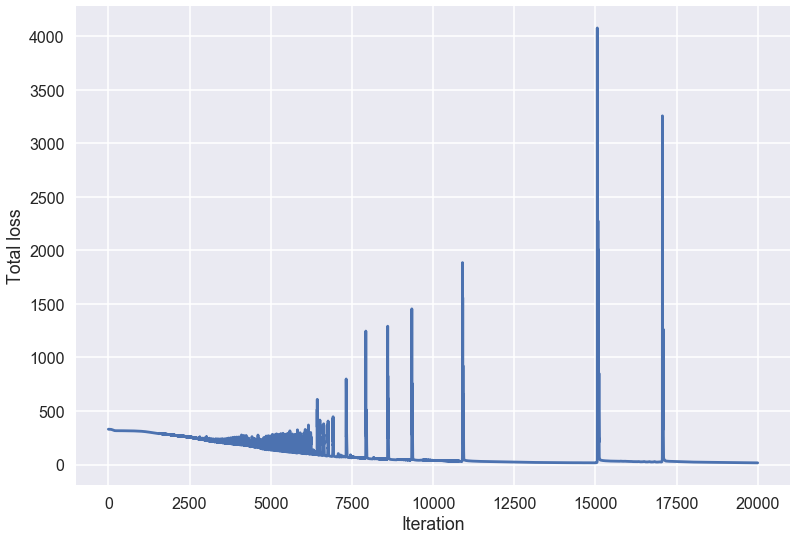

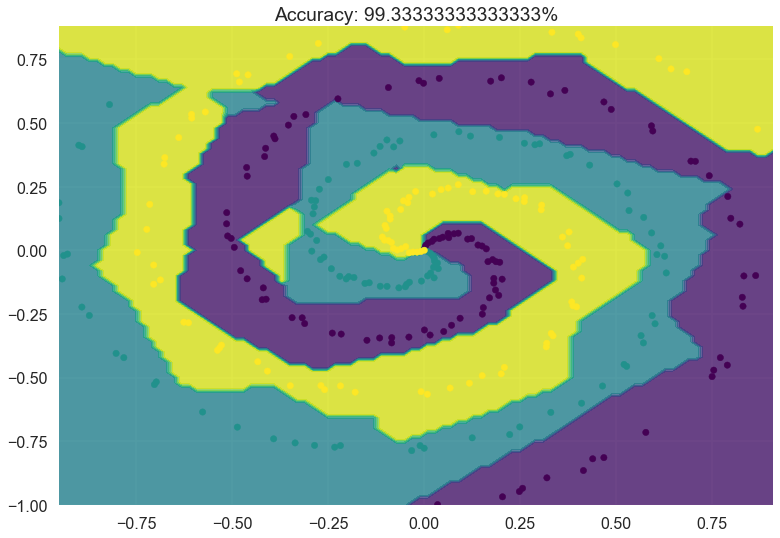

In [6]:
model = SingleLayerReLU(100, K)
losses = model.fit(X, y, step_size=2e-3, n_iter=20000)
plt.plot(losses, '-')
plt.xlabel('Iteration')
plt.ylabel('Total loss');
plt.figure()
visualize_predictions(model, X, y)

### 2c) (optional) Numerically check the gradient implementation in `dloss`
This is an extremely important step when coding derivatives by hand: check the gradients returned by `dloss` by perturbing a single weight value by $\epsilon$ and comparing the resulting change in loss to what you'd expect from the gradient.

<sub>\* This is a bit of an abuse of notation since we're taking some derivatives with respect to vectors/matrices; this just means a vector/matrix of derivatives with respect to each element.</sub>  
<sub>\*\* For an excrutiating amount of detail about backprop, see e.g. [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html).</sub>

In [7]:
dW1, dW2, db1, db2 = model.dloss(X, y)
h = 1e-6
i = 0; j = 0
l0 = model.loss(y, model.predict_proba(X))
model.W1[i, j] += h
lh = model.loss(y, model.predict_proba(X))
print("Derivative: {}; Numerical esitmate: {}".format(dW1[i, j], (lh - l0) / h))

Derivative: -0.03241138676097138; Numerical esitmate: -0.03241135537734863


## Part 3: Compare with `scikit-learn`
The `scikit-learn` package does contain a minimal implementation of a neural network classifier in `scikit-learn.neural_networks.MLPClassifier`. This classifier is nowhere near as powerful or fully-featured as the neural networks provided by other packages such as `tensorflow`, `theano`, etc., but it still can represent complicated non-linear relationships within small datasets.

### 3a) Implement a simple neural network classifier using `scikit-learn`
What parameter values give a network comparable to the one we implemented above? Note that the results may not be equivalent since `scikit-learn` version could reach a different set of (locally) optimal parameters.

Hint: try using `solver='lbfgs'` (a more complicated optimization method) for better results.

### 3b) Experiment with different activations/network sizes
How do the decision boundaries change for different models?

### 3c) Experiment with different numbers of classes and noise levels
Go back to where we initialized the data and change the parameters `K` and `sigma`. Can a single- or multi-layer perceptron still represent more complicated patterns?

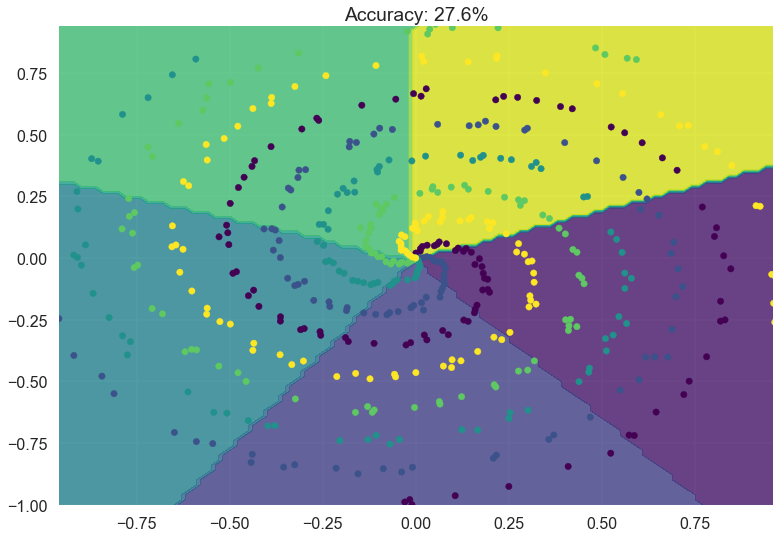

In [8]:
from sklearn.neural_network import MLPClassifier

X, y = spiral_data(100, 5, 0.1)
single_layer_model = MLPClassifier((8,), activation='identity', solver='lbfgs')
single_layer_model.fit(X, y)
visualize_predictions(single_layer_model, X, y)

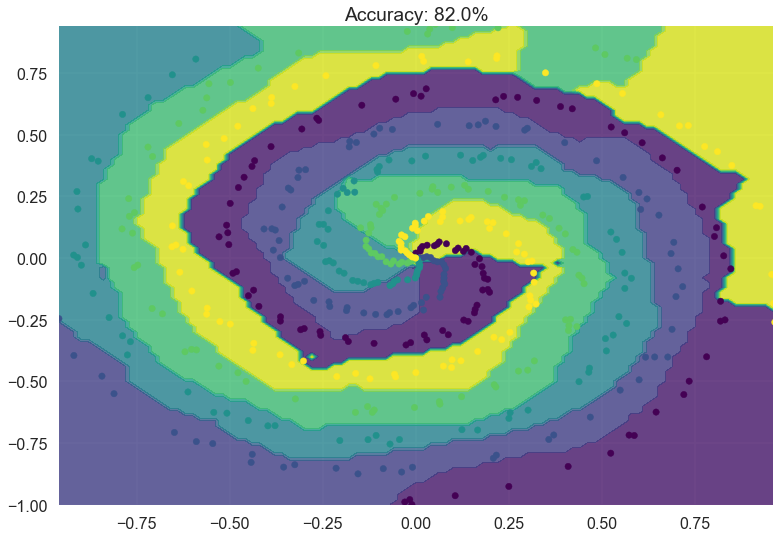

In [9]:
multi_layer_model = MLPClassifier((100, 100), alpha=0.5, activation='relu', solver='lbfgs')
multi_layer_model.fit(X, y)
visualize_predictions(multi_layer_model, X, y)

## Part 4: Visualize neuron activations (optional)
Interpreting neural network classifiers can be quite difficult, especially when the network contains many layers. One way of attempting to make sense of the model is by visualizing the activations of individual neurons: by plotting the activation of a neuron over the entire input space, we can see what patterns the neurons are learning to represent.

Try below to generate plots that show the activation of an individual neuron. `scikit-learn` doesn't make this immediately available, but we can make it work: try setting the last layer's weights (in `coefs_[-1]`) to zero for everything except a single unit, and setting that unit's weights to 1 (so that the activation just passes straight through). You can re-use most of the code from `visualize_predictions` to generate a contour map of activation strengths.

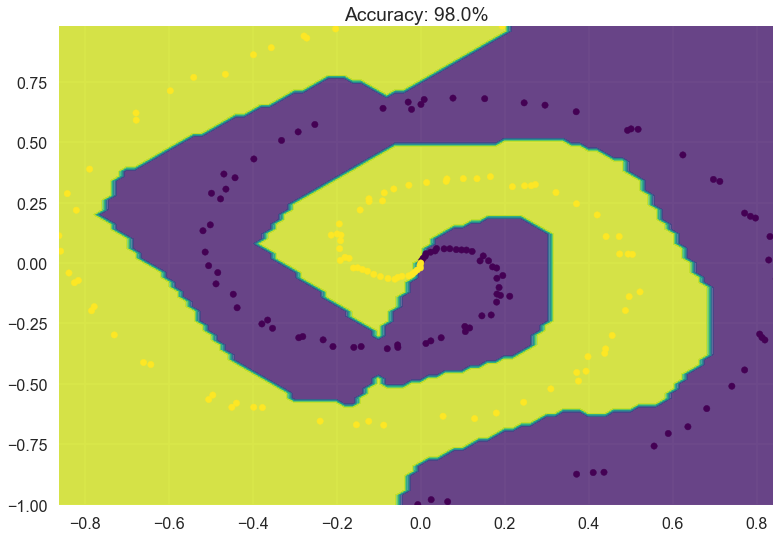

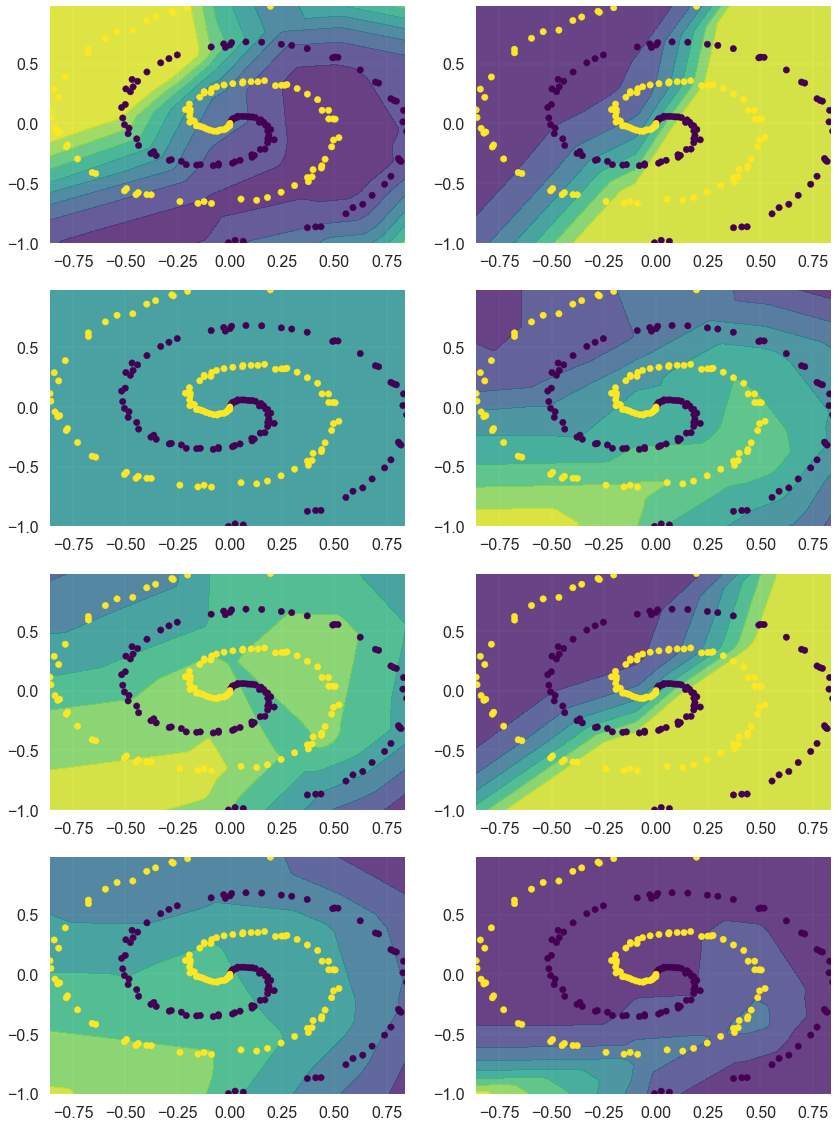

In [10]:
from copy import deepcopy

X, y = spiral_data(100, 2, 0.1)
multi_layer_model = MLPClassifier((64, 8), alpha=0.5, activation='relu', solver='lbfgs')
multi_layer_model.fit(X, y)
visualize_predictions(multi_layer_model, X, y)

def visualize_activations(model, unit, X, y, step=0.02):
    """Visualize activations of ith neuron of last layer."""
    model = deepcopy(model)
    model.coefs_[-1][:unit] = 0  # zero out other units
    model.coefs_[-1][unit] = 1  # just want the activation function
    model.coefs_[-1][(unit + 1):] = 0  # zero out other units
    
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
fig, ax = plt.subplots(4, 2, figsize=(14, 20))
for i in range(len(multi_layer_model.coefs_[-1])):
    plt.sca(ax.ravel()[i])
    visualize_activations(multi_layer_model, i, X, y)